# Clustering and PCA

### Mushroom Dataset

Podeis obtener el conjunto de datos en el siguiente enlace:

[Mushroom Dataset](https://www.kaggle.com/uciml/mushroom-classification)

Como podréis comprobar, hay muchas variables, todas ellas categóricas, por lo que exploraciones con scatterplot no nos serán útiles como en otros casos.

La variable a predecir ``class`` es binaria.


In [13]:
# Carga de librerías, las que hemos considerado básicas, añadid lo que queráis :)

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Leer conjunto de datos y primer vistazo

In [15]:
# Leer el csv y sacar por pantalla las cinco primeras filas.
df = pd.read_csv("data/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Exploración de datos

In [16]:
# Descripción del conjunto de datos, estándard.
df.describe(include='all')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [17]:
# Información sobre el tipo de datos de cada feature.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

#### Calcular el número de nulos de cada feature

In [20]:
# Igual que otras veces, una linea, contar los nulos por variable.
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

#### Buscar valores extraños. Para ello, ver los valores únicos en cada feature

In [22]:
# Obtener un nuevo dataframe de dos columnas donde en la primera estén las features (features) y en la otra los valores únicos
# asociados (n_values).
unique_values = pd.DataFrame({
    'features': df.columns,
    'n_values': [df[col].unique() for col in df.columns]
})
unique_values
unique_vals = pd.DataFrame({
    'features': df.columns,
    'n_values': [df[col].unique() for col in df.columns]
})
unique_vals


,features,n_values
0,class,"[p, e]"
1,cap-shape,"[x, b, s, f, k, c]"
2,cap-surface,"[s, y, f, g]"
3,cap-color,"[n, y, w, g, e, p, b, u, c, r]"
4,bruises,"[t, f]"
5,odor,"[p, a, l, n, f, c, y, s, m]"
6,gill-attachment,"[f, a]"
7,gill-spacing,"[c, w]"
8,gill-size,"[n, b]"
9,gill-color,"[k, n, g, p, w, h, u, e, b, r, y, o]"


#### Tratar aquellos valores que entendamos que sean nulos


In [23]:
# Imputaciones. Podéis quitar esos puntos (fila entera), imputar con la moda o dejar ese valor como una posibilidad más.

df.replace('?', np.nan, inplace=True)
df = df.dropna()  # o imputar con df.fillna(df.mode().iloc[0])


#### Mirad cuántos valores hay en cada feature, ¿Todas las features aportan información? Si alguna no aporta información, eliminadla

In [24]:
# Dejar por el camino si procede.
for col in df.columns:
    if df[col].nunique() == 1:
        print(f'Drop {col}')
        df.drop(columns=col, inplace=True)


Drop veil-type


#### Separar entre variables predictoras y variables a predecir

In [27]:
# La variable que trata de predecir este conjunto de datos es 'class'.
y = df['class']
X = df.drop(columns='class')
# Convertir las variables categóricas en variables dummy.
X = pd.get_dummies(X, drop_first=True)


#### Codificar correctamente las variables categóricas a numéricas

In [48]:
# One Hot Encoder (una linea).
X = pd.get_dummies(X)


#### Train test split

In [49]:
# Os lo dejamos a todos igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## PCA

Es un conjunto de datos del que aún no hemos visto nada (no tenemos graficas) así que vamos a hacer algunas. Tenemos el problema de que son muchas variables, **PCA al rescate**: le pedimos que nos de dos dimensiones y las pintamos, sabemos que serán **aquellas que retengan más información**.

/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.compon

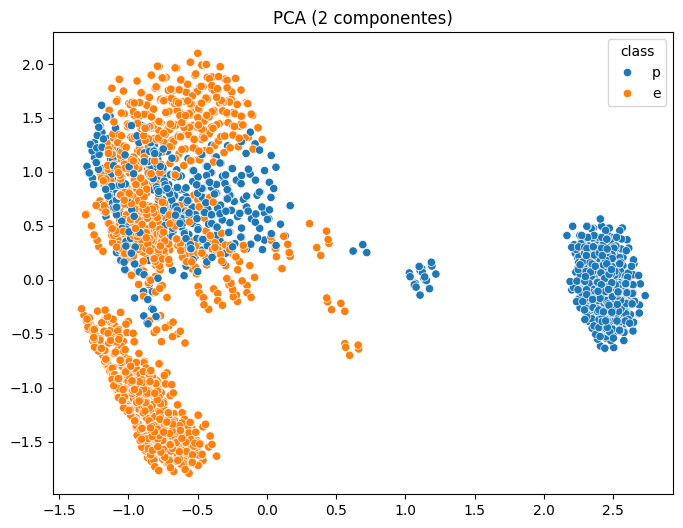

In [36]:
pca = PCA(n_components=2)  # Define PCA with 2 components
X_train_pca = pca.fit_transform(X_train)  # Fit and transform X_train



# Representar en un scatterplot y poner en color las etiquetas de entrenamiento
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title('PCA (2 componentes)')
plt.show()

Parece que está bastante separadito, parece que a ojo mucho se puede ver :)

Igualmente, vamos a entrenar un clasificador a ver qué tal lo hace antes de editar más

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

# 1. Definir el clasificador y el número de estimadores
# 2. Entrenar en train
# 3. Calcular la precisión sobre test

1.0

Es un conjunto sencillo y Random Forest es muy bueno en su trabajo, Igualmente, vamos a ver qué tamaño tenemos de dataset:


In [51]:
X_train.shape

(3781, 76)

¿Muchas features no? Vamos a reducir las usando PCA.

/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.compon

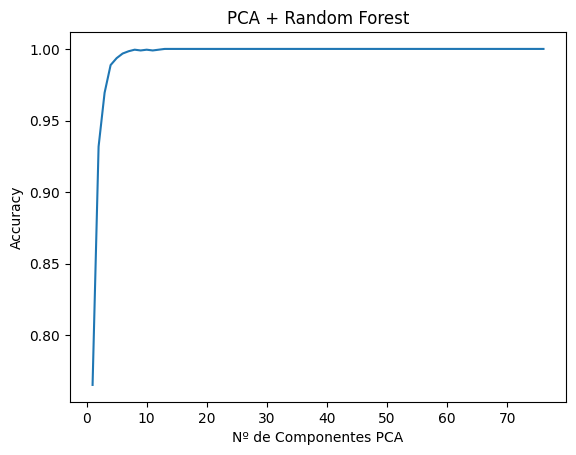

In [41]:
n_features = range(1, X_train.shape[1]+1)
scores = []

for n in n_features:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_pca, y_train)
    score = rf.score(X_test_pca, y_test)
    scores.append(score)

sns.lineplot(x=n_features, y=scores)
plt.xlabel('Nº de Componentes PCA')
plt.ylabel('Accuracy')
plt.title('PCA + Random Forest')
plt.show()



Vale, estamos viendo que a partir de unas 10 features ya tenemos el score que queríamos y además hemos reducido las variables a un 10% de las que teníamos, incluso menos que las variables originales.

## Clustering

Viendo que el conjunto de datos es sencillito, podemos intentar hacer algo de clustering a ver qué información podemos obtener.

El primer paso va a ser importar la función de Kmeans de sklearn, y a partir de ahi, vamos a buscar el valor óptimo de clusters. Como hemos visto anteriormente, este valor lo obtenemos, por ejemplo, del codo de la gráfica que representa el total de las distancias de los puntos a los centros de los clusters asociados. Os dejo la página de la documentación de sklearn para que lo busquéis:

[K-Means on sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Con esto solo hay que ahora generar los modelos de kmeans, evaluar y pintar la gráfica para los valores de ``k`` que establezcais.




/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/

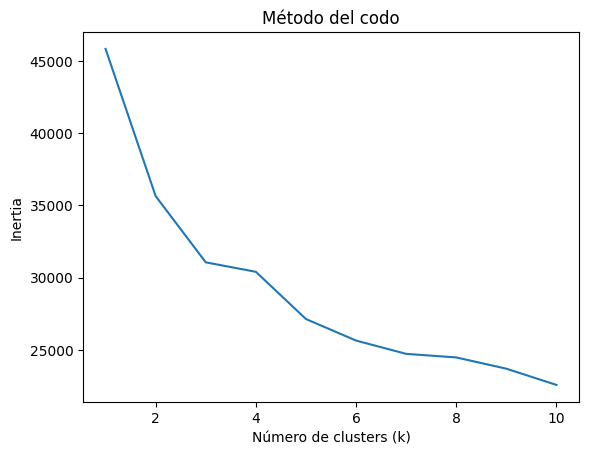

In [43]:
from sklearn.cluster import KMeans

    # Definir Kmeans y ajustar
    # Guardar la predicción

scores = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    scores.append(kmeans.inertia_)

sns.lineplot(x=k_values, y=scores)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del codo')
plt.show()


Con el valor que hayáis obtenido de la gráfica, podéis obtener una buena aproximación de Kmeans y con ello podemos pasar a explorar cómo de bien han separado la información los distintos clusters. Para ello, se va a hacer un ``catplot``, seaborn os lo hará solito. Con esto lo que se pretende ver es la distribución de la varaible a predecir en función del cluster que haya determinado Kmeans.

/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/

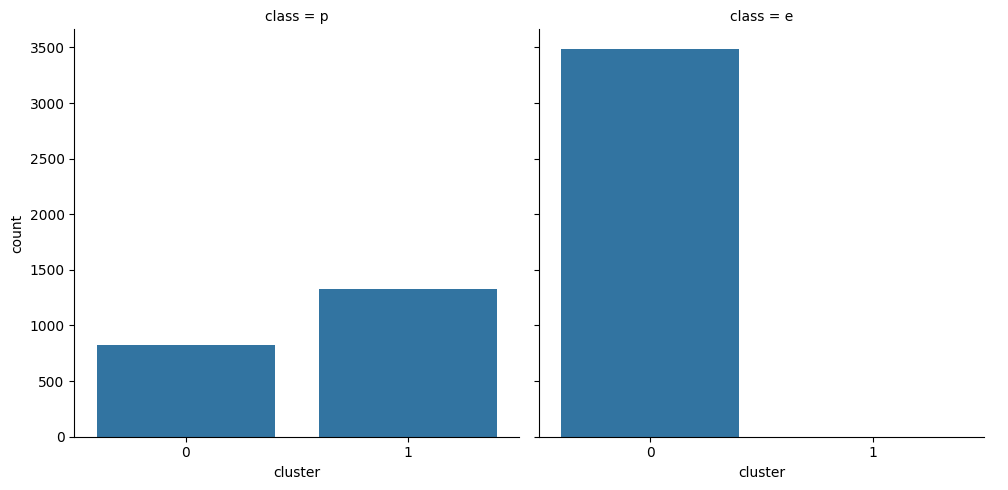

In [ ]:

best_k = 2  # o el k óptimo según el gráfico anterior
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)
ax = sns.catplot(data=df, x='cluster', col='class', kind='count')

# Pintar.
# sns.catplot(col=, x=, data=, kind='count',col_wrap=4)

Vamos a ver qué tal queda esto pintado. Para ello, repetimos el scatterplot de antes pero usando como color el cluster asignado por kmeans.

/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/andresuescum/Bootcamp/aprendizaje_no_supervisado/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.compon

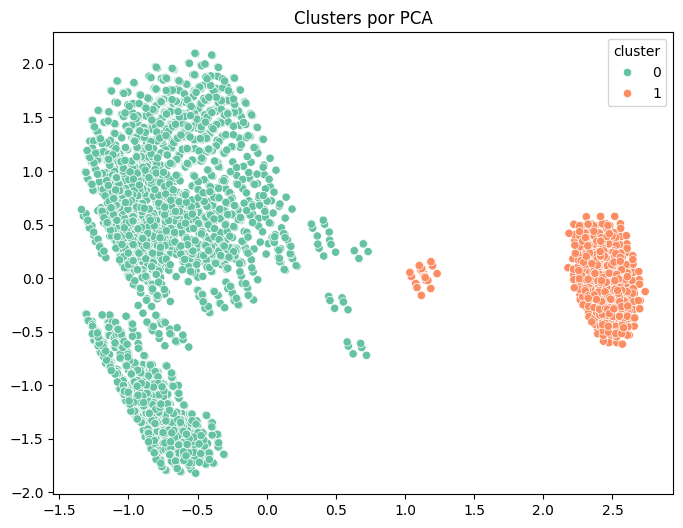

In [47]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set2')
plt.title('Clusters por PCA')
plt.show()



¿Es bastante parecido no? No es tan bueno como el Random Forest, pero ha conseguido identificar bastante bien los distintos puntos del dataset sin utilizar las etiquetas. De hecho, el diagrama de factor que hemos visto antes muestra que solo un par de clusters son imprecisos. Si no hubieramos tenido etiquetas esta aproximacion nos hubiera ayudado mucho a clasificar los distintos tipos de hongos.